# 3. DBSCAN

In [1]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
iris=load_iris()
feature_names=['sepal_length','sepal_width','petal_length','petal_width']

irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target']=iris.target

- DBSCAN 클래스를 이용해서 iris데이터셋 군집화

In [4]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster']=dbscan_labels
irisDF['target']=iris.target

iris_result=irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
iris_result

# 군집레이블 -1은 노이즈에 속하는 군집을 의미.
# target 유형은 3가지이지만, 군집은 2개로 나뉘었다.
# 그러나 군집화의 효율이 떨어진 것은 아님
# DBSCAN은 군집의 개수를 자동 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미하다.

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64

- 군집화된 데이터셋을 시각화
    - 2차원 평면에 표현하기 위해 PCA를 통해 2개의 feature로 변환
    - visualize_cluster_plot() 함수를 통해 시각화

In [5]:
def visualize_cluster_plot(clusterobj, dataframe, label_name,iscenter=True):
    
    # GMM은 center속성이 없음. KMeans는 있음.
    if iscenter:
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o','s','^','x','*']
    isNoise=False
    
    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label== -1:
            cluster_legend='Noise'
            isNoise=True
        else:
            cluster_legend = 'Cluster'+str(label)  #cluster0, cluster1..
            
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                   edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0],y=center_x_y[1], s=250, color='white',
                       alpha = 0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0],y=center_x_y[1], s=70, color='k',
                       edgecolor='k', marker='$%d$' % label)
            
    if isNoise:
        legend_loc = 'upper right'
    else: legend_loc='upper right'
        
    plt.legend(loc=legend_loc)
    plt.show()

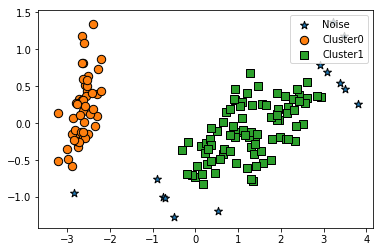

In [6]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2, random_state=0)
pca_transformed=pca.fit_transform(iris.data)

irisDF['ftr1']=pca_transformed[:,0]
irisDF['ftr2']=pca_transformed[:,1]

visualize_cluster_plot(dbscan,irisDF, 'dbscan_cluster', iscenter=False)

- eps 값을 0.8로 증가시키기 0.6->0.8
    - eps값을 크게하면 반경이 커지기때문에, 노이즈 개수가 줄어든다.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


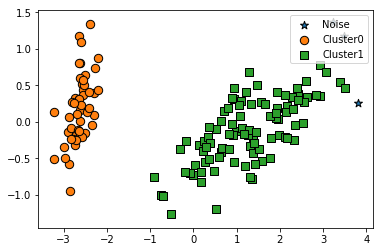

In [8]:
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster']=dbscan_labels
irisDF['target']=iris.target

iris_result=irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan,irisDF, 'dbscan_cluster', iscenter=False)

# noise가 3개로 줄어들었다.

- min_samples를 크게 하기 8 -> 16 으로 변경
    - 크게 하면 주어진 반경내에서 더 많은 데이터를 포함시켜야 하기 때문에 noise 개수가 많아진다.

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


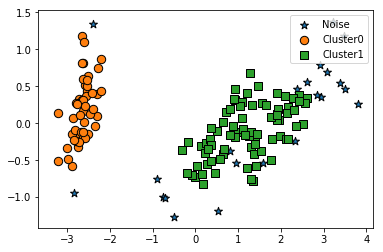

In [10]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster']=dbscan_labels
irisDF['target']=iris.target

iris_result=irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan,irisDF, 'dbscan_cluster', iscenter=False)

# noise가 기존보다 많이 증가했다.

### make_circles() 데이터 셋 실습
- 내부원과 외부원 형태로 되어잇는 2차원 데이터셋 생성
- 생성한 데이터셋으로 다양한 군집화 모델을 적용하고 비교

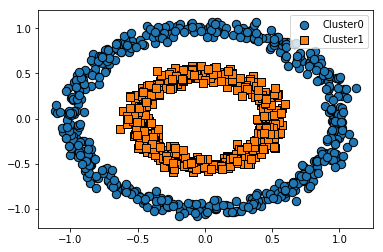

In [12]:
from sklearn.datasets import make_circles

X,y=make_circles(n_samples=1000, shuffle=True, noise=0.05,
                random_state=0, factor=0.5)

clusterDF=pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target']=y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

1) K-means

- kmeans는 원형의 분포가 아닌 불특정한 분포는 군집화가 어렵다.
- 위, 아래 절반으로 군집화가 됌.

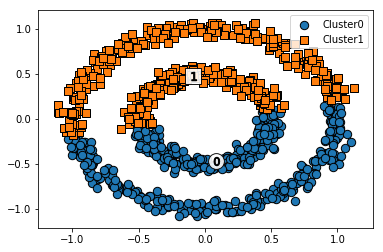

In [18]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)

clusterDF['kmeans_cluster']=kmeans_labels


visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

2) GMM
- GMM도 길쭉한 방향으로 데이터가 밀집해 있는 경우가 아니면 군집화가 적절하지 않다.

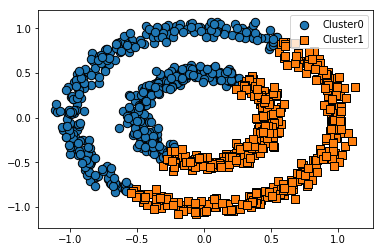

In [21]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label=gmm.fit(X).predict(X)
clusterDF['gmm_cluster']=gmm_label


visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

3) DBSCAN
- 원한느 방향으로 정확히 군집화가 됌

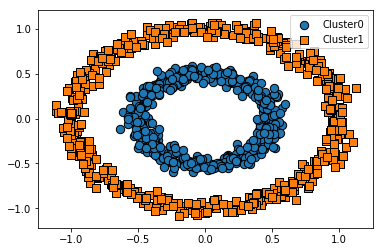

In [24]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster']=dbscan_labels


visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)